In [1]:
!pip install MetaTrader5

Defaulting to user installation because normal site-packages is not writeable


In [25]:
import MetaTrader5 as mt5
import pandas as pd
import time
import numpy as np

def initialize():
    # Connect to MetaTrader 5
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        return False
    
    # Login to your trading account
    login = 78800425
    password = "!8TgVgZs"
    server = "MetaQuotes-Demo"
    authorized = mt5.login(login, password,server)
    
    if not authorized:
        print("Failed to login to MetaTrader 5 account. Please check your credentials.")
        return False
    
    print("Connected to MetaTrader 5 account:", login)
    return True

def close():
    # Shutdown MetaTrader 5
    mt5.shutdown()

def fetch_data(symbol, timeframe, limit):
    # Fetch historical data
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, limit)
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

def crossover_strategy(data, short_window, long_window):
    # Calculate moving averages
    data['short_mavg'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    data['long_mavg'] = data['close'].rolling(window=long_window, min_periods=1).mean()

    # Generate buy/sell signals
    data['signal'] = 0
    data.loc[data['short_mavg'] > data['long_mavg'], 'signal'] = 1
    data.loc[data['short_mavg'] < data['long_mavg'], 'signal'] = -1
#     print(data['signal'].tail(3))
    # return data['signal'].iloc[-1]
    return data
initialize()
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H4
short_window = 10
long_window = 50
limit = 1000
data = fetch_data(symbol, timeframe, limit)
data
# Compute simple returns
data['simple_return'] = data['close'].pct_change() * 100
# crossover_strategy(data, short_window, long_window)
# Compute log returns
# data['log_return'] = data['close'].apply(lambda x: None if x == 0 else np.log(x / data['close'].shift(1)))

data.tail(10)

Connected to MetaTrader 5 account: 78800425


,open,high,low,close,tick_volume,spread,real_volume,simple_return
time,,,,,,,,
2024-02-01 08:00:00,1.08028,1.08053,1.07799,1.07987,39505,0,0,-0.037028
2024-02-01 12:00:00,1.07988,1.08275,1.07915,1.08140,50200,0,0,0.141684
2024-02-01 16:00:00,1.08138,1.08748,1.08059,1.08728,99412,0,0,0.543740
2024-02-01 20:00:00,1.08727,1.08749,1.08626,1.08709,40561,1,0,-0.017475
2024-02-02 00:00:00,1.08710,1.08799,1.08626,1.08714,11393,2,0,0.004599
2024-02-02 04:00:00,1.08714,1.08825,1.08712,1.08774,12490,0,0,0.055191
2024-02-02 08:00:00,1.08774,1.08976,1.08735,1.08909,26861,0,0,0.124111
2024-02-02 12:00:00,1.08909,1.08950,1.08037,1.08074,47225,0,0,-0.766695
2024-02-02 16:00:00,1.08072,1.08172,1.07805,1.07835,84770,0,0,-0.221145


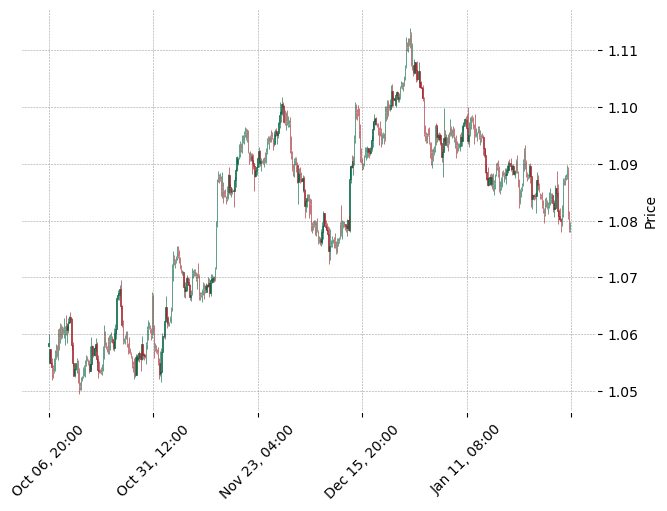

Index(['open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume',
       'simple_return'],
      dtype='object')

In [26]:
import pandas as pd
import mplfinance as mpf


# Plotting candlestick chart
mpf.plot(data.tail(500), type='candle', style='charles', volume=False)
data.columns

In [ ]:
def main():
    if not initialize():
        return

    symbol = "EURUSD"
    timeframe = mt5.TIMEFRAME_M5
    short_window = 5
    long_window = 15
    limit = 1000

    while True:
        data = fetch_data(symbol, timeframe, limit)
        signal = crossover_strategy(data, short_window, long_window)
        print(signal)
    
        if signal == 1:
            print("Buy signal detected")
            request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": "EURUSD",
                "volume": 2.0, # FLOAT
                "type": mt5.ORDER_TYPE_BUY,
                "price": mt5.symbol_info_tick("EURUSD").ask,
                "sl": 0.0, # FLOAT
                "tp": 0.0, # FLOAT
                "deviation": 100, # INTERGER
                "magic": 234000, # INTERGER
                "comment": "python script open",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }

            result = mt5.order_send(request)
            print(result)
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print("Failed to execute buy order:", result.comment)
        elif signal == -1:
            print("Sell signal detected")
            # Execute a sell order
            request = {
                "action": mt5.TRADE_ACTION_DEAL,
                "symbol": "EURUSD",
                "volume": 2.0, # FLOAT
                "type": mt5.ORDER_TYPE_SELL,
                #"position": 158631228, # select the position you want to close
                "price": mt5.symbol_info_tick("EURUSD").ask,
                "sl": 0.0, # FLOAT
                "tp": 0.0, # FLOAT
                "deviation": 100, # INTERGER
                "magic": 234000, # INTERGER
                "comment": "python script open",
                "type_time": mt5.ORDER_TIME_GTC,
                "type_filling": mt5.ORDER_FILLING_IOC,
            }

            result = mt5.order_send(request)
            print(result)
            if result.retcode != mt5.TRADE_RETCODE_DONE:
                print("Failed to execute sell order:", result.comment)

        time.sleep(300)  # Check for signals every 60 seconds

    close()

if __name__ == "__main__":
    main()


In [ ]:
# login 78800425
# password !8TgVgZs
# readonly password *6JmFsEv

In [5]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import time
def trade(signal):
    if signal == 1:
        print("Buy signal detected")
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": "EURUSD",
            "volume": 2.0, # FLOAT
            "type": mt5.ORDER_TYPE_BUY,
            "price": mt5.symbol_info_tick("EURUSD").ask,
            "sl": 0.0, # FLOAT
            "tp": 0.0, # FLOAT
            "deviation": 20, # INTERGER
            "magic": 234000, # INTERGER
            "comment": "python script open",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }

        result = mt5.order_send(request)
        print(result)
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print("Failed to execute buy order:", result.comment)
    elif signal == 0:
        print("Sell signal detected")
        # Execute a sell order
        request = {
            "action": mt5.TRADE_ACTION_DEAL,
            "symbol": "EURUSD",
            "volume": 2.0, # FLOAT
            "type": mt5.ORDER_TYPE_SELL,
            #"position": 158631228, # select the position you want to close
            "price": mt5.symbol_info_tick("EURUSD").ask,
            "sl": 0.0, # FLOAT
            "tp": 0.0, # FLOAT
            "deviation": 20, # INTERGER
            "magic": 234000, # INTERGER
            "comment": "python script open",
            "type_time": mt5.ORDER_TIME_GTC,
            "type_filling": mt5.ORDER_FILLING_IOC,
        }

        result = mt5.order_send(request)
        print(result)
        if result.retcode != mt5.TRADE_RETCODE_DONE:
            print("Failed to execute sell order:", result.comment)




In [6]:
def initialize():
    """
    Connects to MetaTrader 5 and logs in to a trading account.
    """
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        return False
    
    # Login to your trading account
    login = 78800425
    password = "!8TgVgZs"
    server = "MetaQuotes-Demo"
    authorized = mt5.login(login, password, server)

In [ ]:
def close_previous_positions(trade_signal, symbol="EURUSD"):
    """
    Closes previous positions if trade signal changes.
    """
    positions = mt5.positions_get(symbol=symbol)
    print(positions)
    if positions is not None:
        for position in positions:
            print(position.type,trade_signal)
            if trade_signal == position.type:
                close_position(position)

                
def reverse(type):
    if type == mt5.ORDER_TYPE_BUY:
        return mt5.ORDER_TYPE_SELL
    elif type == mt5.ORDER_TYPE_SELL:
        return mt5.ORDER_TYPE_BUY
        
    
def close_position(position):
    """
    Closes a specific position.
    """
    # Retrieve symbol information
    symbol_info = mt5.symbol_info(position.symbol)
    if not symbol_info.visible:
        print("Symbol not found or not tradable:", position.symbol)
        return

    # Determine closing price based on position type
    if position.type == mt5.ORDER_TYPE_BUY:
        closing_price = symbol_info.bid
    elif position.type == mt5.ORDER_TYPE_SELL:
        closing_price = symbol_info.ask
    else:
        print("Invalid position type:", position.type)
        return
#     print(reverse(position.type))
    # Close position
    request = {
        "action": mt5.TRADE_ACTION_DEAL,
        "position": position.ticket,
        "type": reverse(position.type),
        "volume": position.volume,
        "symbol": position.symbol,
        "price": closing_price,
        "comment": "Closing position",
        "type_time": mt5.ORDER_TIME_GTC,
        "type_filling": mt5.ORDER_FILLING_IOC,
        "deviation":20
    }

    # Send order to close position
    result = mt5.order_send(request)
    if result.retcode == mt5.TRADE_RETCODE_DONE:
        print("Closed position:", position.ticket)
    else:
        print("Failed to close position. Error code:", result.retcode)
        print("Error comment:", result.comment)

In [ ]:
close_previous_positions(1)

In [9]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np

def initialize():
    """
    Connects to MetaTrader 5 and logs in to a trading account.
    """
    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        return False
    
    # Login to your trading account
    login = 78800425
    password = "!8TgVgZs"
    server = "MetaQuotes-Demo"
    authorized = mt5.login(login, password, server)
    
    if not authorized:
        print("Failed to login to MetaTrader 5 account. Please check your credentials.")
        return False
    
    print("Connected to MetaTrader 5 account:", login)
    return True

def close():
    """
    Shuts down the MetaTrader 5 connection.
    """
    mt5.shutdown()

def fetch_data(symbol, timeframe, limit):
    """
    Fetches historical OHLCV data for a given symbol, timeframe, and limit.
    """
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, limit)
    df = pd.DataFrame(rates)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

def moving_average_crossover_signal(data, short_window, long_window):
    """
    Generates buy signals based on a simple moving average crossover strategy.
    """
    data['short_mavg'] = data['close'].rolling(window=short_window, min_periods=1).mean()
    data['long_mavg'] = data['close'].rolling(window=long_window, min_periods=1).mean()
    
    # Generate buy signals when short-term moving average crosses above long-term moving average
    signals = np.where(data['short_mavg'] > data['long_mavg'], 1, 0)
    
    return signals

def rsi_signal(data, window=14, threshold=30):
    """
    Generates buy signals based on the Relative Strength Index (RSI) indicator.
    """
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    # Generate buy signals when RSI crosses below a specified threshold
    signals = np.where(rsi < threshold, 1, 0)
    
    return signals

def macd_signal(data, short_window=12, long_window=26, signal_window=9):
    """
    Generates buy signals based on the Moving Average Convergence Divergence (MACD) indicator.
    """
    exp_short = data['close'].ewm(span=short_window, adjust=False).mean()
    exp_long = data['close'].ewm(span=long_window, adjust=False).mean()
    macd_line = exp_short - exp_long
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    
    # Generate buy signals when MACD line crosses above signal line
    signals = np.where(macd_line > signal_line, 1, 0)
    
    return signals

def combine_signals(signals_list):
    """
    Combines signals from multiple strategies into a single array.
    """
    combined_signals = np.sum(signals_list, axis=0)
    return combined_signals

def generate_trade_signal(combined_signals):
    """
    Generates a trade signal based on the consensus of combined signals.
    """
    majority_buy = np.sum(combined_signals == 1) > len(combined_signals) / 2
    majority_sell = np.sum(combined_signals == -1) > len(combined_signals) / 2

    if majority_buy:
        return 1  # Buy signal
    elif majority_sell:
        return -1  # Sell signal
    else:
        return 0  # No signal

def main():
    if not initialize():
        return

    symbol = "EURUSD"
    timeframe = mt5.TIMEFRAME_M5
    limit = 1000
   

    while True:
        # Fetch historical data
        data = fetch_data(symbol, timeframe, limit)

        # Define parameters for moving average crossover strategy
        short_window = 5
        long_window = 20

        # Generate buy signals based on different strategies
        ma_crossover_signals = moving_average_crossover_signal(data, short_window, long_window)
        rsi_signals = rsi_signal(data)
        macd_signals = macd_signal(data)
        # Combine signals from different strategies
        combined_signals = combine_signals([ma_crossover_signals, rsi_signals, macd_signals])

        # Generate a single trade signal based on the consensus of combined signals
        trade_signal = generate_trade_signal(combined_signals)


#         Close previous positions
#         close_previous_positions(trade_signal)
        print(trade_signal)
    
#         trade(trade_signal)
        time.sleep(60)
        
#     close()

if __name__ == "__main__":
    main()


Connected to MetaTrader 5 account: 78800425
0


KeyboardInterrupt: 